In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# DF 불러오기

In [34]:
df0 = pd.read_csv('./after_preprocessing_data/df_final_0627.csv')

In [35]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536097 entries, 0 to 536096
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   자치구                536097 non-null  object 
 1   계약일                536097 non-null  object 
 2   건물면적(㎡)            536097 non-null  float64
 3   층                  536097 non-null  int64  
 4   KOSPI종가            536097 non-null  float64
 5   Fed기준금리            536097 non-null  float64
 6   국제유가(Dubai)($/배럴)  536097 non-null  float64
 7   부동산거래량             536097 non-null  int64  
 8   국고채5년(평균)          536097 non-null  float64
 9   국고채10년(평균)         536097 non-null  float64
 10  회사채3년(평균)          536097 non-null  float64
 11  CD91물(평균)          536097 non-null  float64
 12  BOK기준금리            536097 non-null  float64
 13  건물연식               536097 non-null  int64  
 14  GDP대비가계부채비율        536097 non-null  float64
 15  환율종가               536097 non-null  float64
 16  금값

## LTV 컬럼 추가 
- 계약일 
- 거래가격(=물건금액)
> 2가지 조건을 고려하여 LTV 값 대입 

- 서울
    - 투기과열지구 : 서울 전역 포함(17.08.02 ~ 23.01)
    - 서울 내에서 투기지역 구분 의미 X 

- 고려하지 못한 조건
    - 소득
    - 주택 소유 및 다주택 여부 
    

In [36]:
# LTV 파생변수 생성
df0['LTV'] = np.NaN

# 타입 변환
df0['계약일'] = pd.to_datetime(df0['계약일'])

df0.loc[df0['계약일'] <= '2017-06-19', 'LTV'] = 0.7

# 17.06.19 
df0.loc[(df0['계약일'] > '2017-06-19')& (df0['계약일'] <= '2017-08-02'), 'LTV'] = 0.6

# 17.08.02
df0.loc[(df0['계약일'] > '2017-08-02')&(df0['계약일'] <= '2018-09-14'), 'LTV'] = 0.4

# 18.09.13 -> 1주택 가정 
    # 서울 전체 주택보유자 비율 훨씬 높음 2:1 
    # 부동산 거래Data 중에서도 서울 APT를 사는 사람은 기존 보유주택을 팔고 온것이라 가정
# df0.loc[(df0['계약일'] > '2018-09-14')& (df0['계약일'] <= '2019-12-15'), 'LTV'] = 0.4
# df0.loc[((df0['계약일'] > '2018-09-14')& (df0['계약일'] <= '2019-12-15')) & (df0['물건금액(만원)']>90000), 'LTV'] = 0
df0.loc[(df0['계약일'] > '2018-09-14')& (df0['계약일'] <= '2019-12-16'), 'LTV'] = 0

# 19.12.16
df0.loc[(df0['계약일'] > '2019-12-16'), 'LTV'] = 0.4
df0.loc[(df0['계약일'] > '2019-12-16') & (df0['물건금액(만원)'] > 90000), 'LTV'] = 0.2
df0.loc[(df0['계약일'] > '2019-12-16') & (df0['물건금액(만원)'] > 150000), 'LTV'] = 0

In [37]:
df0['LTV'].value_counts()

0.4    214414
0.7    162023
0.0    101431
0.2     38933
0.6     19296
Name: LTV, dtype: int64

### LTV -> Label Encoding(보류)


# Train/Test Split


In [38]:
# Train : 2016-2020
# Test : 2021-2022

df0['계약일'] = pd.to_datetime(df0['계약일'])

In [39]:
train_df = df0.loc[df0['계약일'] < '2021']

In [40]:
test_df = df0.loc[df0['계약일'] >= '2021']

## feature & target split

In [41]:
# Train Split
# feature & target  split

X_train_df = train_df.drop('물건금액(만원)', axis=1)
y = train_df['물건금액(만원)']

# X_train : 숫자형 컬럼만 
X_train = X_train_df.select_dtypes([np.number])

In [42]:
# Test Split
# feature & target  split

X_test_df = test_df.drop('물건금액(만원)', axis=1)
y_test = test_df['물건금액(만원)']

# X_test : 숫자형 컬럼만 
X_test = X_test_df.select_dtypes([np.number])

---

# Scaling
1. Features - minMax
2. Target - Log 

In [43]:
# minMax
from sklearn.preprocessing import MinMaxScaler

# Scaler 객체 생성
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [44]:
# y -> log 변환

# Train
y_scaled = np.log10(y)
# y_scaled

# Test
y_test_scaled = np.log10(y_test)
y_test_scaled

453170    4.716003
453171    4.722634
453172    4.380211
453173    5.079181
453174    4.361728
            ...   
536092    5.397940
536093    5.139879
536094    5.235528
536095    4.568202
536096    4.883661
Name: 물건금액(만원), Length: 82927, dtype: float64

# OLS - Scaling 후

## OLS_1

In [45]:
# OLS_0
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                 2.584e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:40:50   Log-Likelihood:             1.3131e+05
No. Observations:              453170   AIC:                        -2.626e+05
Df Residuals:                  453150   BIC:                        -2.624e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.5791      0.008    559.029      0.000       4.563       4.595
건물면적(㎡)               2.2003      0.004    584.514      0.000       2.193       2.208
층                     0.2742      0.003     84.615      0.000       0.268       0.281
KOSPI종가               0.0259      0.006      4.084      0.000       0.013       0.038
Fed기준금리              -0.1425      0.004    -37.715      0.000      -0.150      -0.135
국제유가(Dubai)($/배럴)     0.1723      0.004     39.741      0.000       0.164       0.181
부동산거래량                0.0016      0.002      0.722      0.470      -0.003       0.006
국고채5년(평균)            -0.3747      0.020    -19.125      0.000      -0.413      -0.336
국고채10년(평균)            0.3153      0.014     22.201      0.000       0.287       0.343
회사채3년(평균)             0.1033      0.006     17.099      0.000       0.091       0.115
CD91물(평균)            -0.0879      0.009    -10.046      0.000      -0.105      -0.071
BOK기준금리              -0.0639      0.007     -8.531      0.000      -0.079      -0.049
건물연식                 -0.0050      0.002     -2.861      0.004      -0.008      -0.002
GDP대비가계부채비율          -0.0650      0.005    -12.940      0.000      -0.075      -0.055
환율종가                  0.0099      0.003      3.054      0.002       0.004       0.016
금값종가                  0.0583      0.005     12.222      0.000       0.049       0.068
선행지수순환변동치             0.1370      0.005     28.830      0.000       0.128       0.146
EPU                  -0.0075      0.002     -3.802      0.000      -0.011      -0.004
장단기금리spread          -0.2229      0.009    -24.749      0.000      -0.241      -0.205
LTV                  -0.2777      0.002   -131.009      0.000      -0.282      -0.274
==============================================================================
Omnibus:                    10921.587   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12461.300
Skew:                           0.347   Prob(JB):                         0.00
Kurtosis:                       3.421   Cond. No.                         202.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

In [46]:
X_scaled.drop('부동산거래량', axis=1, inplace=True)

In [47]:
# OLS_1
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                 2.727e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:40:51   Log-Likelihood:             1.3131e+05
No. Observations:              453170   AIC:                        -2.626e+05
Df Residuals:                  453151   BIC:                        -2.624e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.5781      0.008    566.153      0.000       4.562       4.594
건물면적(㎡)               2.2004      0.004    584.595      0.000       2.193       2.208
층                     0.2742      0.003     84.613      0.000       0.268       0.281
KOSPI종가               0.0271      0.006      4.432      0.000       0.015       0.039
Fed기준금리              -0.1429      0.004    -38.208      0.000      -0.150      -0.136
국제유가(Dubai)($/배럴)     0.1736      0.004     43.602      0.000       0.166       0.181
국고채5년(평균)            -0.3766      0.019    -19.390      0.000      -0.415      -0.339
국고채10년(평균)            0.3160      0.014     22.301      0.000       0.288       0.344
회사채3년(평균)             0.1019      0.006     17.797      0.000       0.091       0.113
CD91물(평균)            -0.0879      0.009    -10.047      0.000      -0.105      -0.071
BOK기준금리              -0.0636      0.007     -8.503      0.000      -0.078      -0.049
건물연식                 -0.0050      0.002     -2.872      0.004      -0.008      -0.002
GDP대비가계부채비율          -0.0652      0.005    -12.998      0.000      -0.075      -0.055
환율종가                  0.0099      0.003      3.068      0.002       0.004       0.016
금값종가                  0.0600      0.004     14.367      0.000       0.052       0.068
선행지수순환변동치             0.1366      0.005     28.882      0.000       0.127       0.146
EPU                  -0.0078      0.002     -4.000      0.000      -0.012      -0.004
장단기금리spread          -0.2210      0.009    -25.686      0.000      -0.238      -0.204
LTV                  -0.2774      0.002   -133.806      0.000      -0.281      -0.273
==============================================================================
Omnibus:                    10916.452   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12454.891
Skew:                           0.347   Prob(JB):                         0.00
Kurtosis:                       3.421   Cond. No.                         197.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# VIF_1
from statsmodels.stats.outliers_influence import variance_inflation_factor

def feature_engineering_XbyVIF(X_scaled):
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(X_scaled.values,i)
                         for i in range(X_scaled.shape[1])]
    vif["Feature"] = X_scaled.columns
    return vif


In [49]:
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

     VIF_Factor            Feature
0      6.309358            건물면적(㎡)
1      5.095493                  층
2    126.783942            KOSPI종가
3     50.391298            Fed기준금리
4     76.625107  국제유가(Dubai)($/배럴)
5   1155.573691          국고채5년(평균)
6    793.073506         국고채10년(평균)
7    120.525879          회사채3년(평균)
8    329.697449          CD91물(평균)
9    272.098273            BOK기준금리
10     5.607387               건물연식
11    64.608910        GDP대비가계부채비율
12    28.954342               환율종가
13    20.740890               금값종가
14   120.430659          선행지수순환변동치
15     5.309569                EPU
16   190.661625        장단기금리spread
17    26.511475                LTV


In [50]:
X_scaled.drop('국고채5년(평균)', axis=1, inplace=True)

In [51]:
# OLS_2
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                 2.883e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:41:15   Log-Likelihood:             1.3112e+05
No. Observations:              453170   AIC:                        -2.622e+05
Df Residuals:                  453152   BIC:                        -2.620e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.6461      0.007    637.338      0.000       4.632       4.660
건물면적(㎡)               2.2010      0.004    584.560      0.000       2.194       2.208
층                     0.2740      0.003     84.514      0.000       0.268       0.280
KOSPI종가               0.0170      0.006      2.793      0.005       0.005       0.029
Fed기준금리              -0.1555      0.004    -42.188      0.000      -0.163      -0.148
국제유가(Dubai)($/배럴)     0.1718      0.004     43.149      0.000       0.164       0.180
국고채10년(평균)            0.0982      0.009     11.364      0.000       0.081       0.115
회사채3년(평균)             0.0697      0.005     12.710      0.000       0.059       0.080
CD91물(평균)            -0.1405      0.008    -16.895      0.000      -0.157      -0.124
BOK기준금리              -0.1300      0.007    -19.547      0.000      -0.143      -0.117
건물연식                 -0.0047      0.002     -2.695      0.007      -0.008      -0.001
GDP대비가계부채비율          -0.0471      0.005     -9.563      0.000      -0.057      -0.037
환율종가                  0.0353      0.003     11.897      0.000       0.029       0.041
금값종가                  0.0495      0.004     11.958      0.000       0.041       0.058
선행지수순환변동치             0.1469      0.005     31.243      0.000       0.138       0.156
EPU                  -0.0172      0.002     -9.150      0.000      -0.021      -0.014
장단기금리spread          -0.3292      0.007    -50.270      0.000      -0.342      -0.316
LTV                  -0.2700      0.002   -132.447      0.000      -0.274      -0.266
==============================================================================
Omnibus:                    10994.415   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12519.811
Skew:                           0.350   Prob(JB):                         0.00
Kurtosis:                       3.417   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# VIF_2
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

    VIF_Factor            Feature
0     6.275346            건물면적(㎡)
1     5.088570                  층
2   125.116490            KOSPI종가
3    46.351649            Fed기준금리
4    76.601642  국제유가(Dubai)($/배럴)
5   231.012772         국고채10년(평균)
6   111.416431          회사채3년(평균)
7   326.098930          CD91물(평균)
8   242.675948            BOK기준금리
9     5.595296               건물연식
10   54.052368        GDP대비가계부채비율
11   19.616717               환율종가
12   20.563182               금값종가
13  117.794389          선행지수순환변동치
14    5.182175                EPU
15  135.929816        장단기금리spread
16   22.210734                LTV


In [53]:
X_scaled.drop('CD91물(평균)', axis=1, inplace=True)

In [54]:
# OLS_3
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                 3.059e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:41:35   Log-Likelihood:             1.3098e+05
No. Observations:              453170   AIC:                        -2.619e+05
Df Residuals:                  453153   BIC:                        -2.617e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.5889      0.006    710.478      0.000       4.576       4.602
건물면적(㎡)               2.2020      0.004    584.699      0.000       2.195       2.209
층                     0.2740      0.003     84.502      0.000       0.268       0.280
KOSPI종가               0.0423      0.006      7.150      0.000       0.031       0.054
Fed기준금리              -0.1587      0.004    -43.100      0.000      -0.166      -0.151
국제유가(Dubai)($/배럴)     0.1615      0.004     41.042      0.000       0.154       0.169
국고채10년(평균)            0.0098      0.007      1.420      0.156      -0.004       0.023
회사채3년(평균)             0.1039      0.005     20.375      0.000       0.094       0.114
BOK기준금리              -0.1950      0.005    -35.944      0.000      -0.206      -0.184
건물연식                 -0.0046      0.002     -2.641      0.008      -0.008      -0.001
GDP대비가계부채비율          -0.0366      0.005     -7.493      0.000      -0.046      -0.027
환율종가                  0.0446      0.003     15.276      0.000       0.039       0.050
금값종가                  0.0250      0.004      6.442      0.000       0.017       0.033
선행지수순환변동치             0.1677      0.005     36.944      0.000       0.159       0.177
EPU                  -0.0170      0.002     -9.062      0.000      -0.021      -0.013
장단기금리spread          -0.3023      0.006    -47.575      0.000      -0.315      -0.290
LTV                  -0.2681      0.002   -131.686      0.000      -0.272      -0.264
==============================================================================
Omnibus:                    11113.972   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12662.561
Skew:                           0.352   Prob(JB):                         0.00
Kurtosis:                       3.418   Cond. No.                         77.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
X_scaled.drop('국고채10년(평균)', axis=1, inplace=True)

In [56]:
# OLS_4
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                 3.263e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:41:36   Log-Likelihood:             1.3097e+05
No. Observations:              453170   AIC:                        -2.619e+05
Df Residuals:                  453154   BIC:                        -2.617e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.5865      0.006    737.368      0.000       4.574       4.599
건물면적(㎡)               2.2020      0.004    584.698      0.000       2.195       2.209
층                     0.2740      0.003     84.501      0.000       0.268       0.280
KOSPI종가               0.0408      0.006      7.009      0.000       0.029       0.052
Fed기준금리              -0.1578      0.004    -43.529      0.000      -0.165      -0.151
국제유가(Dubai)($/배럴)     0.1619      0.004     41.221      0.000       0.154       0.170
회사채3년(평균)             0.1085      0.004     27.597      0.000       0.101       0.116
BOK기준금리              -0.1924      0.005    -37.720      0.000      -0.202      -0.182
건물연식                 -0.0046      0.002     -2.621      0.009      -0.008      -0.001
GDP대비가계부채비율          -0.0379      0.005     -7.898      0.000      -0.047      -0.029
환율종가                  0.0451      0.003     15.588      0.000       0.039       0.051
금값종가                  0.0260      0.004      6.809      0.000       0.019       0.033
선행지수순환변동치             0.1711      0.004     44.046      0.000       0.163       0.179
EPU                  -0.0166      0.002     -8.951      0.000      -0.020      -0.013
장단기금리spread          -0.2995      0.006    -49.627      0.000      -0.311      -0.288
LTV                  -0.2679      0.002   -131.889      0.000      -0.272      -0.264
==============================================================================
Omnibus:                    11114.899   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12663.365
Skew:                           0.352   Prob(JB):                         0.00
Kurtosis:                       3.418   Cond. No.                         74.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
# VIF_4
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

    VIF_Factor            Feature
0     6.235570            건물면적(㎡)
1     5.072690                  층
2   112.857062            KOSPI종가
3    42.365863            Fed기준금리
4    74.097837  국제유가(Dubai)($/배럴)
5    39.434496          회사채3년(평균)
6    62.235236            BOK기준금리
7     5.584190               건물연식
8    45.291615        GDP대비가계부채비율
9    19.568532               환율종가
10   16.597576               금값종가
11   78.366665          선행지수순환변동치
12    5.090947                EPU
13  129.767697        장단기금리spread
14   20.884089                LTV


In [29]:
# 각 숫자형 변수들의 피어슨 상관 분포를 히트맵으로 출력
def plot_cor(df):

    df_ = df.select_dtypes(include=[np.number])
    df_cor = df_.corr(method='pearson')
    plt.figure(figsize = (15, 15))
    plt.rc('font', family = 'Malgun Gothic')
    sns.heatmap(df_cor, 
                xticklabels = df_cor.columns, 
                yticklabels = df_cor.columns, 
                cmap = 'coolwarm', 
                annot = True,
                annot_kws = {'size':10}, 
                linewidth = 3,
                vmin=-1, vmax=1)

c:\Users\zino0\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
c:\Users\zino0\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\Users\zino0\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


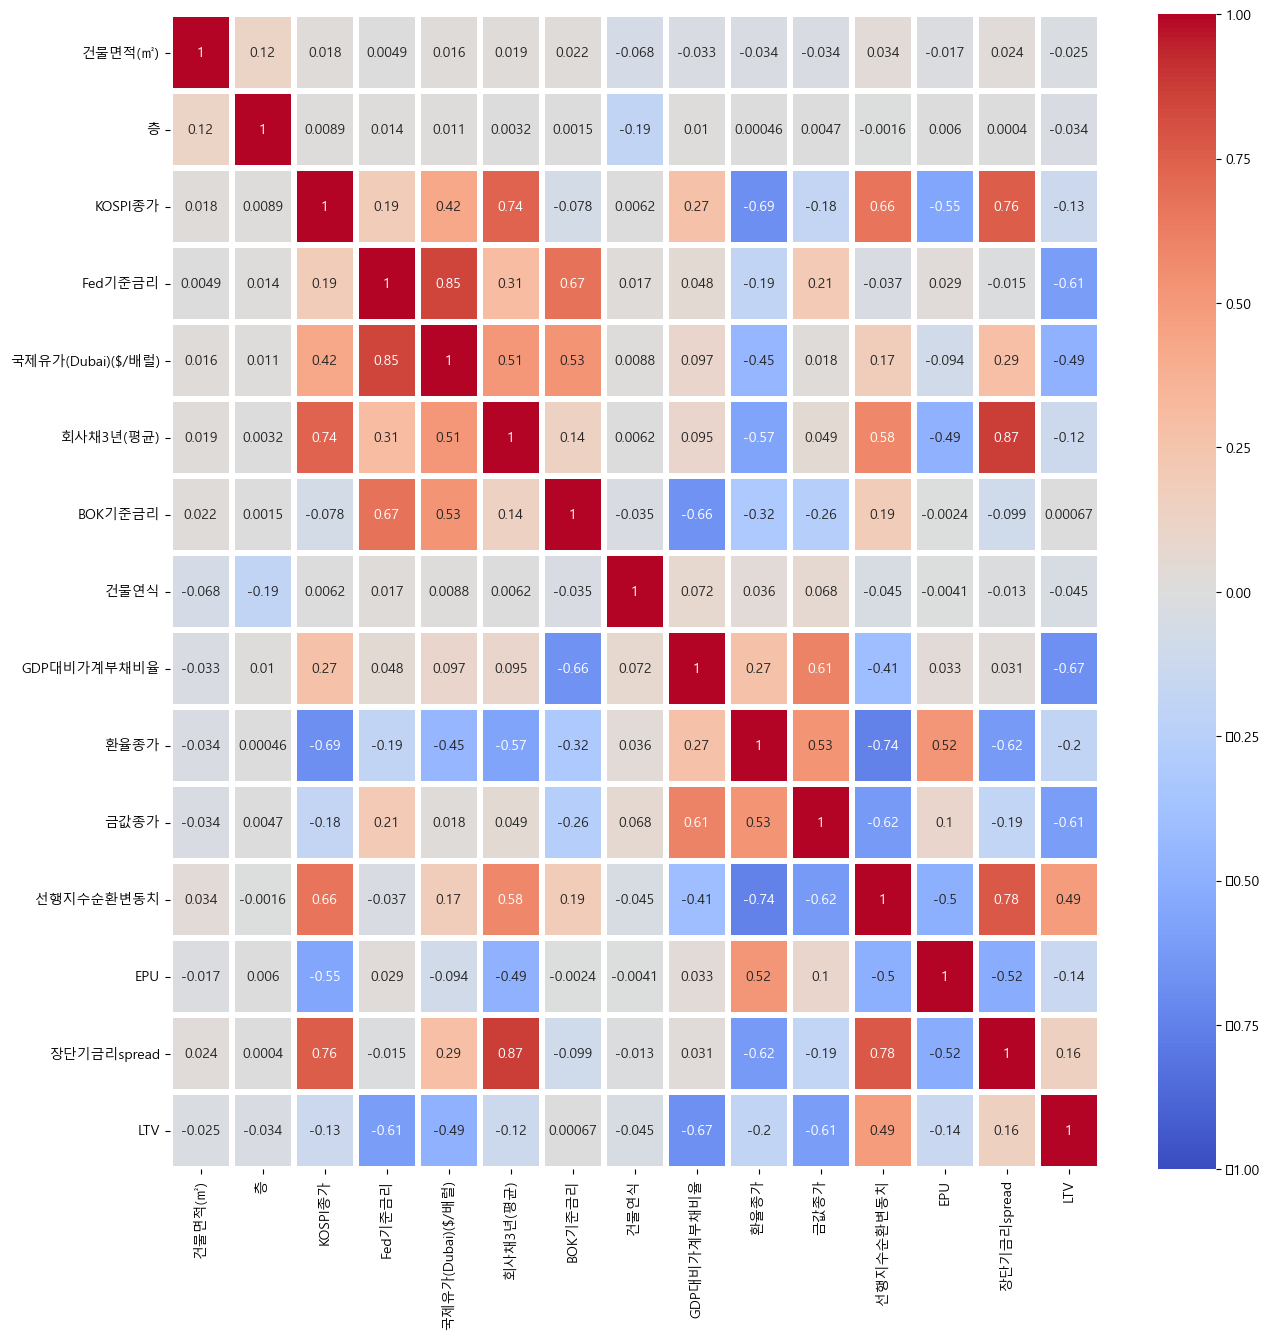

In [30]:
plot_cor(X_scaled)

In [58]:
X_scaled.drop('KOSPI종가', axis=1, inplace=True)

In [59]:
# OLS_5
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                 3.496e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:42:44   Log-Likelihood:             1.3095e+05
No. Observations:              453170   AIC:                        -2.619e+05
Df Residuals:                  453155   BIC:                        -2.617e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.6051      0.006    818.630      0.000       4.594       4.616
건물면적(㎡)               2.2015      0.004    584.637      0.000       2.194       2.209
층                     0.2740      0.003     84.488      0.000       0.268       0.280
Fed기준금리              -0.1588      0.004    -43.847      0.000      -0.166      -0.152
국제유가(Dubai)($/배럴)     0.1632      0.004     41.582      0.000       0.155       0.171
회사채3년(평균)             0.1185      0.004     32.389      0.000       0.111       0.126
BOK기준금리              -0.1952      0.005    -38.375      0.000      -0.205      -0.185
건물연식                 -0.0045      0.002     -2.600      0.009      -0.008      -0.001
GDP대비가계부채비율          -0.0273      0.005     -5.996      0.000      -0.036      -0.018
환율종가                  0.0387      0.003     14.096      0.000       0.033       0.044
금값종가                  0.0222      0.004      5.871      0.000       0.015       0.030
선행지수순환변동치             0.1862      0.003     57.713      0.000       0.180       0.193
EPU                  -0.0194      0.002    -10.676      0.000      -0.023      -0.016
장단기금리spread          -0.3112      0.006    -53.670      0.000      -0.323      -0.300
LTV                  -0.2713      0.002   -137.305      0.000      -0.275      -0.267
==============================================================================
Omnibus:                    11055.819   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12598.119
Skew:                           0.351   Prob(JB):                         0.00
Kurtosis:                       3.419   Cond. No.                         67.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
# VIF_5
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

    VIF_Factor            Feature
0     6.213515            건물면적(㎡)
1     5.060271                  층
2    40.080730            Fed기준금리
3    73.548285  국제유가(Dubai)($/배럴)
4    38.307552          회사채3년(평균)
5    49.763131            BOK기준금리
6     5.570506               건물연식
7    19.157742        GDP대비가계부채비율
8    19.076723               환율종가
9    16.554033               금값종가
10   55.829207          선행지수순환변동치
11    4.968647                EPU
12  128.508848        장단기금리spread
13   20.882766                LTV


c:\Users\zino0\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
c:\Users\zino0\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\Users\zino0\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


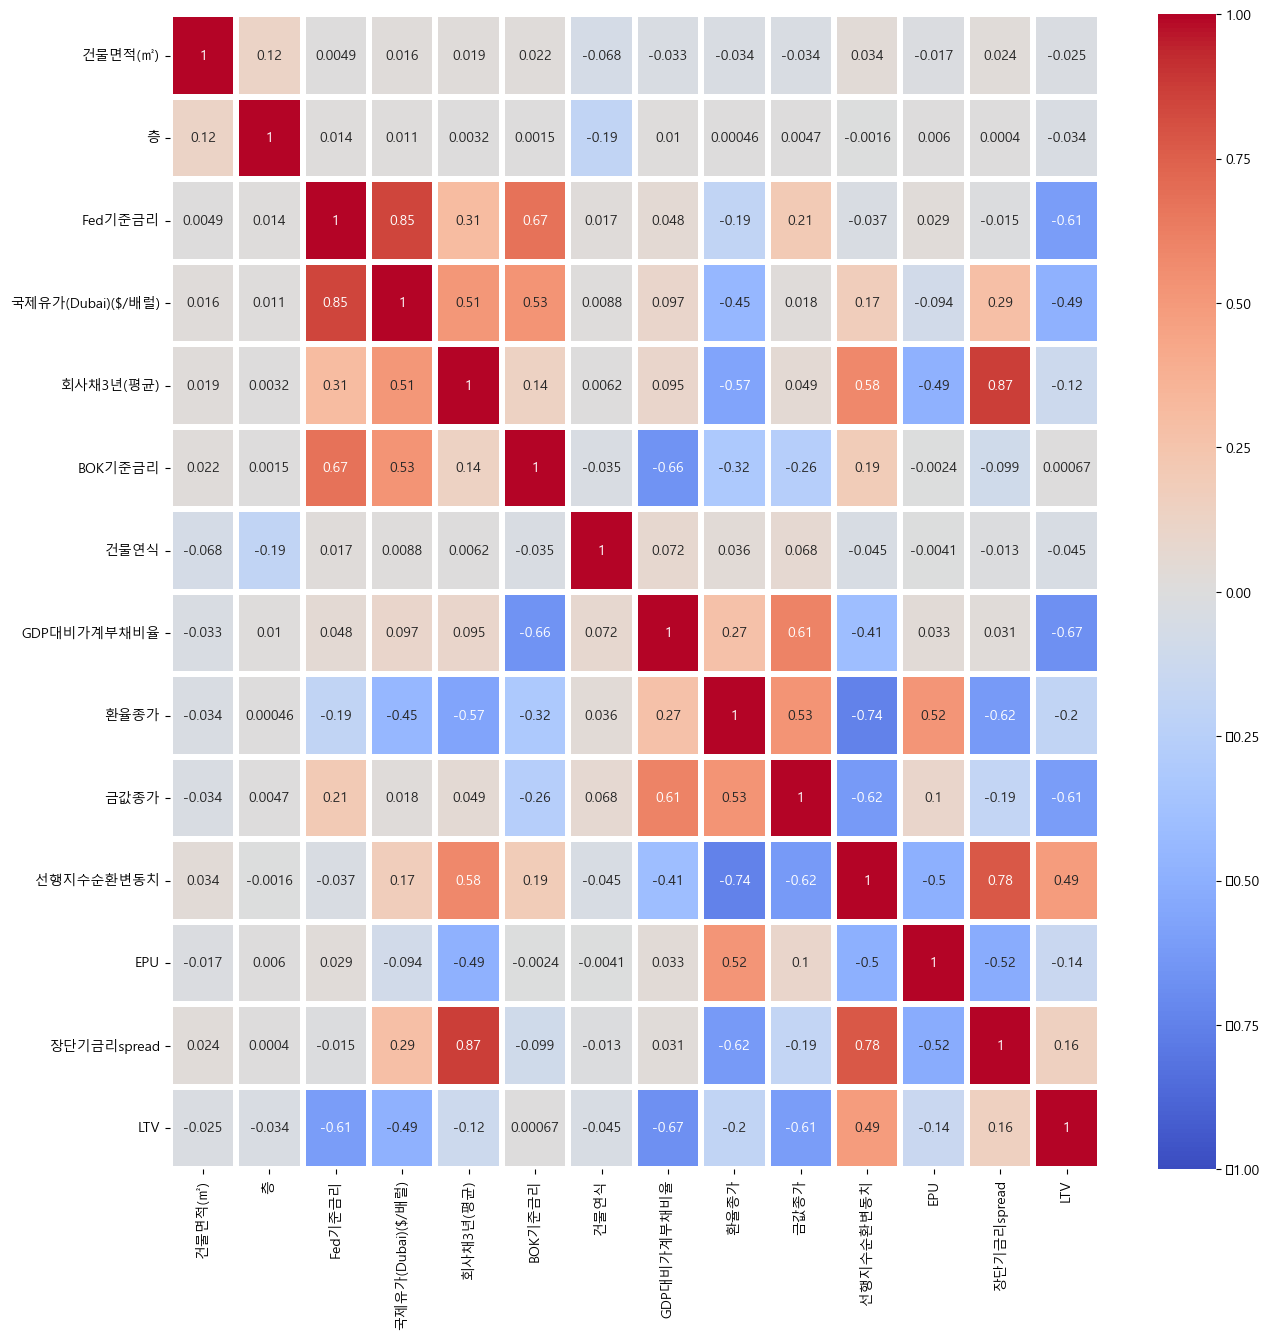

In [61]:
plot_cor(X_scaled)

In [62]:
X_scaled.drop('회사채3년(평균)', axis=1, inplace=True)

In [63]:
# OLS_6
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                 3.748e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:44:38   Log-Likelihood:             1.3043e+05
No. Observations:              453170   AIC:                        -2.608e+05
Df Residuals:                  453156   BIC:                        -2.607e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.5180      0.005    913.192      0.000       4.508       4.528
건물면적(㎡)               2.2041      0.004    584.795      0.000       2.197       2.212
층                     0.2747      0.003     84.602      0.000       0.268       0.281
Fed기준금리              -0.1668      0.004    -46.117      0.000      -0.174      -0.160
국제유가(Dubai)($/배럴)     0.1473      0.004     37.783      0.000       0.140       0.155
BOK기준금리              -0.1065      0.004    -24.815      0.000      -0.115      -0.098
건물연식                 -0.0039      0.002     -2.234      0.026      -0.007      -0.000
GDP대비가계부채비율           0.0318      0.004      7.600      0.000       0.024       0.040
환율종가                  0.0335      0.003     12.198      0.000       0.028       0.039
금값종가                  0.0446      0.004     12.004      0.000       0.037       0.052
선행지수순환변동치             0.1581      0.003     50.806      0.000       0.152       0.164
EPU                  -0.0247      0.002    -13.656      0.000      -0.028      -0.021
장단기금리spread          -0.1549      0.003    -48.127      0.000      -0.161      -0.149
LTV                  -0.2626      0.002   -133.996      0.000      -0.266      -0.259
==============================================================================
Omnibus:                    11237.477   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12801.022
Skew:                           0.355   Prob(JB):                         0.00
Kurtosis:                       3.418   Cond. No.                         52.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
# VIF_6
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

    VIF_Factor            Feature
0     6.180817            건물면적(㎡)
1     5.043758                  층
2    38.965672            Fed기준금리
3    70.595663  국제유가(Dubai)($/배럴)
4    45.564218            BOK기준금리
5     5.558285               건물연식
6    19.156178        GDP대비가계부채비율
7    17.615494               환율종가
8    16.356400               금값종가
9    49.249218          선행지수순환변동치
10    4.849973                EPU
11   46.971908        장단기금리spread
12   20.529925                LTV


In [65]:
X_scaled.drop('국제유가(Dubai)($/배럴)', axis=1, inplace=True)

In [66]:
# OLS_7
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                 4.035e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:46:40   Log-Likelihood:             1.2971e+05
No. Observations:              453170   AIC:                        -2.594e+05
Df Residuals:                  453157   BIC:                        -2.593e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.5533      0.005    935.629      0.000       4.544       4.563
건물면적(㎡)         2.2084      0.004    585.268      0.000       2.201       2.216
층               0.2751      0.003     84.599      0.000       0.269       0.281
Fed기준금리        -0.0807      0.003    -28.691      0.000      -0.086      -0.075
BOK기준금리        -0.0924      0.004    -21.575      0.000      -0.101      -0.084
건물연식           -0.0040      0.002     -2.279      0.023      -0.007      -0.001
GDP대비가계부채비율     0.0634      0.004     15.437      0.000       0.055       0.071
환율종가            0.0032      0.003      1.213      0.225      -0.002       0.008
금값종가           -0.0176      0.003     -5.284      0.000      -0.024      -0.011
선행지수순환변동치       0.1037      0.003     37.533      0.000       0.098       0.109
EPU            -0.0181      0.002    -10.026      0.000      -0.022      -0.015
장단기금리spread    -0.0859      0.003    -32.362      0.000      -0.091      -0.081
LTV            -0.2482      0.002   -128.916      0.000      -0.252      -0.244
==============================================================================
Omnibus:                    11398.840   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12970.776
Skew:                           0.358   Prob(JB):                         0.00
Kurtosis:                       3.416   Cond. No.                         49.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
X_scaled.drop('환율종가', axis=1, inplace=True)

In [69]:
# OLS_8
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                 4.402e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:47:43   Log-Likelihood:             1.2971e+05
No. Observations:              453170   AIC:                        -2.594e+05
Df Residuals:                  453158   BIC:                        -2.593e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.5556      0.004   1023.412      0.000       4.547       4.564
건물면적(㎡)         2.2083      0.004    585.274      0.000       2.201       2.216
층               0.2751      0.003     84.605      0.000       0.269       0.282
Fed기준금리        -0.0806      0.003    -28.665      0.000      -0.086      -0.075
BOK기준금리        -0.0936      0.004    -22.495      0.000      -0.102      -0.085
건물연식           -0.0040      0.002     -2.266      0.023      -0.007      -0.001
GDP대비가계부채비율     0.0624      0.004     15.523      0.000       0.054       0.070
금값종가           -0.0159      0.003     -5.262      0.000      -0.022      -0.010
선행지수순환변동치       0.1033      0.003     37.629      0.000       0.098       0.109
EPU            -0.0174      0.002    -10.223      0.000      -0.021      -0.014
장단기금리spread    -0.0867      0.003    -33.719      0.000      -0.092      -0.082
LTV            -0.2482      0.002   -128.914      0.000      -0.252      -0.244
==============================================================================
Omnibus:                    11398.963   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12969.863
Skew:                           0.358   Prob(JB):                         0.00
Kurtosis:                       3.416   Cond. No.                         46.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
# VIF_8
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

    VIF_Factor      Feature
0     6.111468      건물면적(㎡)
1     5.018473            층
2    23.390304      Fed기준금리
3    38.347531      BOK기준금리
4     5.531832         건물연식
5    11.492881  GDP대비가계부채비율
6    10.294125         금값종가
7    39.677900    선행지수순환변동치
8     3.768268          EPU
9    29.842954  장단기금리spread
10   16.677650          LTV


In [71]:
X_scaled.drop('선행지수순환변동치', axis=1, inplace=True)

In [72]:
# OLS_9
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                 4.813e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:48:31   Log-Likelihood:             1.2901e+05
No. Observations:              453170   AIC:                        -2.580e+05
Df Residuals:                  453159   BIC:                        -2.579e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.5776      0.004   1035.704      0.000       4.569       4.586
건물면적(㎡)         2.2122      0.004    585.614      0.000       2.205       2.220
층               0.2773      0.003     85.140      0.000       0.271       0.284
Fed기준금리        -0.0506      0.003    -18.725      0.000      -0.056      -0.045
BOK기준금리        -0.1062      0.004    -25.562      0.000      -0.114      -0.098
건물연식           -0.0042      0.002     -2.388      0.017      -0.008      -0.001
GDP대비가계부채비율     0.0494      0.004     12.322      0.000       0.042       0.057
금값종가           -0.0879      0.002    -37.349      0.000      -0.093      -0.083
EPU            -0.0352      0.002    -21.588      0.000      -0.038      -0.032
장단기금리spread    -0.0066      0.001     -4.595      0.000      -0.009      -0.004
LTV            -0.2248      0.002   -123.181      0.000      -0.228      -0.221
==============================================================================
Omnibus:                    11431.043   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12964.094
Skew:                           0.360   Prob(JB):                         0.00
Kurtosis:                       3.408   Cond. No.                         43.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
# VIF_9
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

   VIF_Factor      Feature
0    6.091405      건물면적(㎡)
1    5.011385            층
2   21.881428      Fed기준금리
3   38.286877      BOK기준금리
4    5.530623         건물연식
5   11.454237  GDP대비가계부채비율
6    6.294291         금값종가
7    3.530225          EPU
8    8.765850  장단기금리spread
9   12.401706          LTV


In [74]:
X_scaled.drop('BOK기준금리', axis=1, inplace=True)

In [75]:
# OLS_10
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                 5.333e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:49:40   Log-Likelihood:             1.2868e+05
No. Observations:              453170   AIC:                        -2.573e+05
Df Residuals:                  453160   BIC:                        -2.572e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.4879      0.003   1668.052      0.000       4.483       4.493
건물면적(㎡)         2.2160      0.004    586.645      0.000       2.209       2.223
층               0.2781      0.003     85.353      0.000       0.272       0.285
Fed기준금리        -0.1082      0.001    -72.816      0.000      -0.111      -0.105
건물연식           -0.0045      0.002     -2.572      0.010      -0.008      -0.001
GDP대비가계부채비율     0.1374      0.002     66.888      0.000       0.133       0.141
금값종가           -0.0845      0.002    -35.943      0.000      -0.089      -0.080
EPU            -0.0276      0.002    -17.209      0.000      -0.031      -0.024
장단기금리spread     0.0019      0.001      1.337      0.181      -0.001       0.005
LTV            -0.2127      0.002   -120.601      0.000      -0.216      -0.209
==============================================================================
Omnibus:                    11512.370   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13083.808
Skew:                           0.361   Prob(JB):                         0.00
Kurtosis:                       3.414   Cond. No.                         23.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

### 국고채5년(평균), 국고채10년(평균) column 삭제

In [249]:
X_scaled.drop(['국고채5년(평균)','국고채10년(평균)'], axis=1, inplace=True)

In [250]:
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                 2.853e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:40:26   Log-Likelihood:             1.2288e+05
No. Observations:              453170   AIC:                        -2.457e+05
Df Residuals:                  453153   BIC:                        -2.455e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.1742      0.006    743.482      0.000       4.163       4.185
건물면적(㎡)               2.2624      0.004    594.704      0.000       2.255       2.270
층                     0.2877      0.003     87.185      0.000       0.281       0.294
KOSPI종가               0.2314      0.006     37.420      0.000       0.219       0.244
Fed기준금리              -0.0234      0.004     -6.411      0.000      -0.031      -0.016
국제유가(Dubai)($/배럴)     0.1108      0.004     25.277      0.000       0.102       0.119
부동산거래량               -0.0603      0.002    -27.202      0.000      -0.065      -0.056
회사채3년(평균)            -0.0535      0.004    -11.933      0.000      -0.062      -0.045
CD91물(평균)            -0.0998      0.007    -14.729      0.000      -0.113      -0.086
BOK기준금리               0.0331      0.007      5.038      0.000       0.020       0.046
건물연식                 -0.0102      0.002     -5.731      0.000      -0.014      -0.007
GDP대비가계부채비율           0.2008      0.005     43.679      0.000       0.192       0.210
환율종가                  0.0524      0.003     17.730      0.000       0.047       0.058
금값종가                  0.0741      0.005     15.512      0.000       0.065       0.083
선행지수순환변동치            -0.0539      0.004    -15.078      0.000      -0.061      -0.047
EPU                  -0.0123      0.002     -6.315      0.000      -0.016      -0.008
장단기금리spread          -0.0283      0.006     -4.711      0.000      -0.040      -0.017
==============================================================================
Omnibus:                    14025.017   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16013.160
Skew:                           0.409   Prob(JB):                         0.00
Kurtosis:                       3.424   Cond. No.                         69.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- OLS P_value로 제거할 컬럼 없음

## VIF_1

In [251]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def feature_engineering_XbyVIF(X_scaled):
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(X_scaled.values,i)
                         for i in range(X_scaled.shape[1])]
    vif["Feature"] = X_scaled.columns
    return vif


In [252]:
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

    VIF_Factor            Feature
0     6.226946            건물면적(㎡)
1     5.074445                  층
2   125.064469            KOSPI종가
3    28.001589            Fed기준금리
4    87.879257  국제유가(Dubai)($/배럴)
5    12.926349             부동산거래량
6    56.544430          회사채3년(평균)
7   242.311103          CD91물(평균)
8   217.204201            BOK기준금리
9     5.551061               건물연식
10   45.311486        GDP대비가계부채비율
11   18.237495               환율종가
12   25.990298               금값종가
13   66.295687          선행지수순환변동치
14    5.467013                EPU
15  139.057438        장단기금리spread


### CD91물 삭제

In [253]:
X_scaled.drop('CD91물(평균)', axis=1, inplace=True)

## OLS_2

In [254]:
# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                 3.040e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:40:42   Log-Likelihood:             1.2277e+05
No. Observations:              453170   AIC:                        -2.455e+05
Df Residuals:                  453154   BIC:                        -2.453e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.1497      0.005    773.901      0.000       4.139       4.160
건물면적(㎡)               2.2633      0.004    594.879      0.000       2.256       2.271
층                     0.2878      0.003     87.203      0.000       0.281       0.294
KOSPI종가               0.2570      0.006     43.271      0.000       0.245       0.269
Fed기준금리              -0.0302      0.004     -8.338      0.000      -0.037      -0.023
국제유가(Dubai)($/배럴)     0.0986      0.004     22.894      0.000       0.090       0.107
부동산거래량               -0.0570      0.002    -25.853      0.000      -0.061      -0.053
회사채3년(평균)            -0.0556      0.004    -12.411      0.000      -0.064      -0.047
BOK기준금리              -0.0289      0.005     -5.720      0.000      -0.039      -0.019
건물연식                 -0.0103      0.002     -5.804      0.000      -0.014      -0.007
GDP대비가계부채비율           0.2172      0.004     48.698      0.000       0.209       0.226
환율종가                  0.0553      0.003     18.726      0.000       0.049       0.061
금값종가                  0.0472      0.004     10.688      0.000       0.039       0.056
선행지수순환변동치            -0.0603      0.004    -16.996      0.000      -0.067      -0.053
EPU                  -0.0140      0.002     -7.196      0.000      -0.018      -0.010
장단기금리spread          -0.0294      0.006     -4.885      0.000      -0.041      -0.018
==============================================================================
Omnibus:                    14069.217   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16059.713
Skew:                           0.410   Prob(JB):                         0.00
Kurtosis:                       3.423   Cond. No.                         65.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## VIF_2

In [255]:
vif = feature_engineering_XbyVIF(X_scaled)
print(vif)

    VIF_Factor            Feature
0     6.224409            건물면적(㎡)
1     5.070246                  층
2   120.935107            KOSPI종가
3    27.778247            Fed기준금리
4    82.659743  국제유가(Dubai)($/배럴)
5    12.807566             부동산거래량
6    55.680294          회사채3년(평균)
7    60.850672            BOK기준금리
8     5.540469               건물연식
9    44.708803        GDP대비가계부채비율
10   18.046750               환율종가
11   20.860543               금값종가
12   65.086100          선행지수순환변동치
13    5.406565                EPU
14  136.718277        장단기금리spread


### VIF2 & Heatmap

In [256]:
# 각 숫자형 변수들의 피어슨 상관 분포를 히트맵으로 출력
def plot_cor(df):

    df_ = df.select_dtypes(include=[np.number])
    df_cor = df_.corr(method='pearson')
    plt.figure(figsize = (15, 15))
    plt.rc('font', family = 'Malgun Gothic')
    sns.heatmap(df_cor, 
                xticklabels = df_cor.columns, 
                yticklabels = df_cor.columns, 
                cmap = 'coolwarm', 
                annot = True,
                annot_kws = {'size':10}, 
                linewidth = 3,
                vmin=-1, vmax=1)

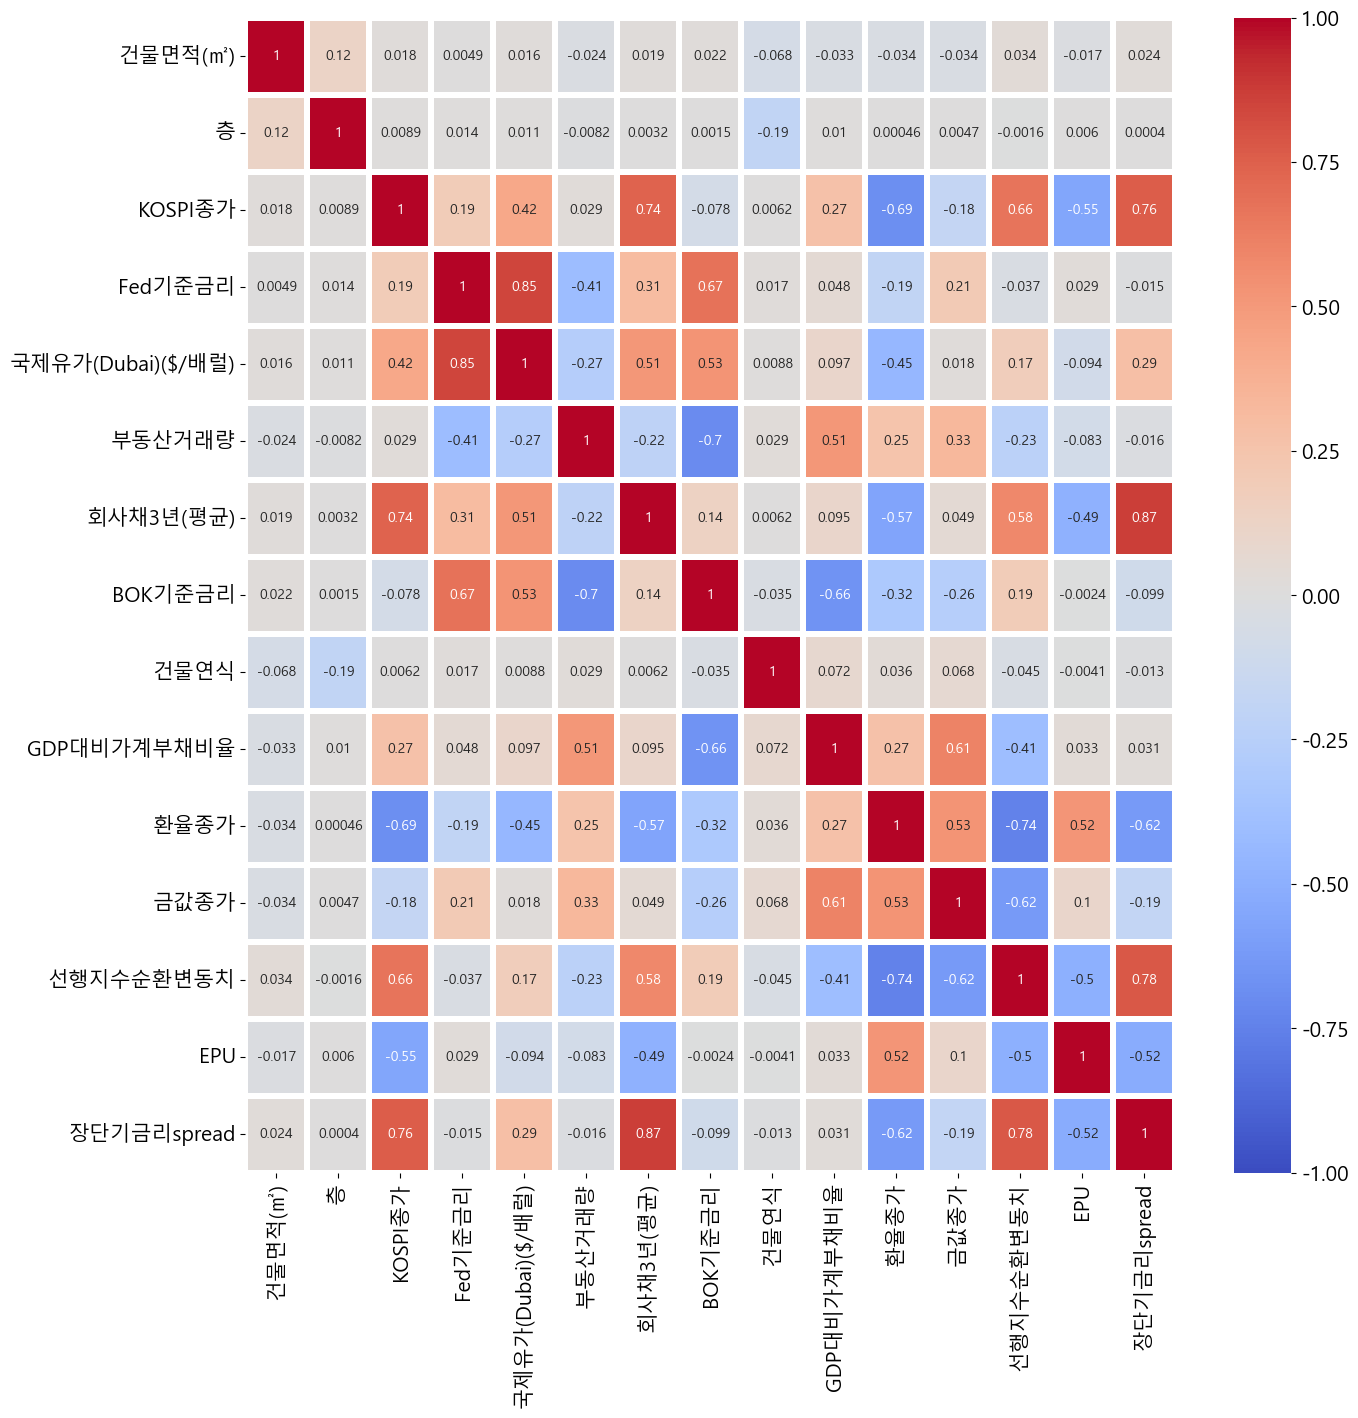

In [257]:
plot_cor(X_scaled)

### 회사채 3년 제거

In [258]:
# 회사채 3년 
X_scaled_1 = X_scaled.drop('회사채3년(평균)', axis=1)

## OLS_3

In [259]:
# ols 3

# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled_1, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                 3.255e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:40:57   Log-Likelihood:             1.2270e+05
No. Observations:              453170   AIC:                        -2.454e+05
Df Residuals:                  453155   BIC:                        -2.452e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.1811      0.005    884.809      0.000       4.172       4.190
건물면적(㎡)               2.2635      0.004    594.849      0.000       2.256       2.271
층                     0.2881      0.003     87.283      0.000       0.282       0.295
KOSPI종가               0.2275      0.005     41.788      0.000       0.217       0.238
Fed기준금리              -0.0198      0.004     -5.601      0.000      -0.027      -0.013
국제유가(Dubai)($/배럴)     0.0916      0.004     21.459      0.000       0.083       0.100
부동산거래량               -0.0437      0.002    -22.676      0.000      -0.047      -0.040
BOK기준금리              -0.0517      0.005    -10.985      0.000      -0.061      -0.042
건물연식                 -0.0105      0.002     -5.905      0.000      -0.014      -0.007
GDP대비가계부채비율           0.2120      0.004     47.726      0.000       0.203       0.221
환율종가                  0.0521      0.003     17.702      0.000       0.046       0.058
금값종가                  0.0244      0.004      6.070      0.000       0.016       0.032
선행지수순환변동치            -0.0454      0.003    -13.592      0.000      -0.052      -0.039
EPU                  -0.0108      0.002     -5.600      0.000      -0.015      -0.007
장단기금리spread          -0.0907      0.003    -26.477      0.000      -0.097      -0.084
==============================================================================
Omnibus:                    14068.123   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16063.407
Skew:                           0.410   Prob(JB):                         0.00
Kurtosis:                       3.424   Cond. No.                         53.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## VIF_3

In [260]:
# vif 3
vif = feature_engineering_XbyVIF(X_scaled_1)
print(vif)

    VIF_Factor            Feature
0     6.193577            건물면적(㎡)
1     5.048821                  층
2   111.412056            KOSPI종가
3    27.479043            Fed기준금리
4    82.544230  국제유가(Dubai)($/배럴)
5     8.924951             부동산거래량
6    60.850671            BOK기준금리
7     5.520038               건물연식
8    43.651592        GDP대비가계부채비율
9    17.319355               환율종가
10   18.472018               금값종가
11   53.636194          선행지수순환변동치
12    5.095194                EPU
13   51.362724        장단기금리spread


### KOSPI종가 삭제

In [261]:
# kospi 종가

X_scaled_2 = X_scaled_1.drop('KOSPI종가', axis=1)

## OLS_4

In [262]:
# OLS 4 

# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled_2, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 3.478e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:41:09   Log-Likelihood:             1.2182e+05
No. Observations:              453170   AIC:                        -2.436e+05
Df Residuals:                  453156   BIC:                        -2.435e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.2222      0.005    911.726      0.000       4.213       4.231
건물면적(㎡)               2.2656      0.004    594.291      0.000       2.258       2.273
층                     0.2892      0.003     87.451      0.000       0.283       0.296
Fed기준금리              -0.0189      0.004     -5.355      0.000      -0.026      -0.012
국제유가(Dubai)($/배럴)     0.0812      0.004     19.013      0.000       0.073       0.090
부동산거래량               -0.0389      0.002    -20.181      0.000      -0.043      -0.035
BOK기준금리              -0.0136      0.005     -2.930      0.003      -0.023      -0.004
건물연식                 -0.0102      0.002     -5.754      0.000      -0.014      -0.007
GDP대비가계부채비율           0.3171      0.004     86.445      0.000       0.310       0.324
환율종가                  0.0126      0.003      4.523      0.000       0.007       0.018
금값종가                  0.0067      0.004      1.686      0.092      -0.001       0.015
선행지수순환변동치             0.0159      0.003      5.299      0.000       0.010       0.022
EPU                  -0.0274      0.002    -14.455      0.000      -0.031      -0.024
장단기금리spread          -0.0732      0.003    -21.499      0.000      -0.080      -0.067
==============================================================================
Omnibus:                    14021.634   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15990.704
Skew:                           0.409   Prob(JB):                         0.00
Kurtosis:                       3.420   Cond. No.                         49.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 금값종가 삭제

In [263]:
# 금값종가 
X_scaled_3 = X_scaled_2.drop('금값종가', axis=1)

## VIF_4

In [264]:
# vif 4
vif = feature_engineering_XbyVIF(X_scaled_3)
print(vif)

    VIF_Factor            Feature
0     6.181885            건물면적(㎡)
1     5.041701                  층
2    20.888462            Fed기준금리
3    61.551941  국제유가(Dubai)($/배럴)
4     7.461052             부동산거래량
5    38.943119            BOK기준금리
6     5.508374               건물연식
7    15.741702        GDP대비가계부채비율
8    14.720578               환율종가
9    21.474473          선행지수순환변동치
10    4.848789                EPU
11   29.034174        장단기금리spread


### 국제유가 삭제

In [265]:
# 국제유가
X_scaled_4 = X_scaled_3.drop('국제유가(Dubai)($/배럴)', axis=1)

## OLS_5

In [266]:
# OLS 5 

# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled_4, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 4.103e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:41:17   Log-Likelihood:             1.2160e+05
No. Observations:              453170   AIC:                        -2.432e+05
Df Residuals:                  453158   BIC:                        -2.430e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.2363      0.005    925.929      0.000       4.227       4.245
건물면적(㎡)         2.2666      0.004    594.349      0.000       2.259       2.274
층               0.2892      0.003     87.393      0.000       0.283       0.296
Fed기준금리         0.0192      0.003      7.005      0.000       0.014       0.025
부동산거래량         -0.0267      0.002    -15.384      0.000      -0.030      -0.023
BOK기준금리         0.0012      0.005      0.255      0.799      -0.008       0.010
건물연식           -0.0102      0.002     -5.728      0.000      -0.014      -0.007
GDP대비가계부채비율     0.3258      0.004     90.715      0.000       0.319       0.333
환율종가           -0.0123      0.002     -5.049      0.000      -0.017      -0.008
선행지수순환변동치       0.0025      0.002      1.097      0.272      -0.002       0.007
EPU            -0.0159      0.002     -8.953      0.000      -0.019      -0.012
장단기금리spread    -0.0461      0.002    -19.754      0.000      -0.051      -0.042
==============================================================================
Omnibus:                    14063.104   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16033.452
Skew:                           0.410   Prob(JB):                         0.00
Kurtosis:                       3.419   Cond. No.                         46.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### BOK기준금리 & 선행지수순환변동치 삭제

In [267]:
# BOK 기준금리, 선행지수순환변동
X_scaled_5 = X_scaled_4.drop(['BOK기준금리', '선행지수순환변동치'], axis=1)

## VIF_5

In [268]:
# vif 5
vif = feature_engineering_XbyVIF(X_scaled_5)
print(vif)

   VIF_Factor      Feature
0    5.728569      건물면적(㎡)
1    4.699360            층
2    3.366467      Fed기준금리
3    6.270897       부동산거래량
4    4.982850         건물연식
5    5.456166  GDP대비가계부채비율
6    9.101714         환율종가
7    4.194596          EPU
8    5.686231  장단기금리spread


## OLS_6

In [269]:
# OLS 6 

# 스케일링 후 predict
import statsmodels.api as sm

feature_add = sm.add_constant(X_scaled_5, has_constant='add')

# sm OLS 적합
model = sm.OLS(y_scaled , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               물건금액(만원)   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 5.014e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:41:22   Log-Likelihood:             1.2160e+05
No. Observations:              453170   AIC:                        -2.432e+05
Df Residuals:                  453160   BIC:                        -2.431e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.2385      0.002   2100.266      0.000       4.235       4.242
건물면적(㎡)         2.2666      0.004    594.410      0.000       2.259       2.274
층               0.2892      0.003     87.402      0.000       0.283       0.296
Fed기준금리         0.0197      0.001     18.185      0.000       0.018       0.022
부동산거래량         -0.0269      0.002    -16.475      0.000      -0.030      -0.024
건물연식           -0.0102      0.002     -5.732      0.000      -0.014      -0.007
GDP대비가계부채비율     0.3240      0.001    226.336      0.000       0.321       0.327
환율종가           -0.0134      0.002     -6.290      0.000      -0.018      -0.009
EPU            -0.0161      0.002     -9.214      0.000      -0.020      -0.013
장단기금리spread    -0.0443      0.002    -27.816      0.000      -0.047      -0.041
==============================================================================
Omnibus:                    14057.163   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16025.338
Skew:                           0.410   Prob(JB):                         0.00
Kurtosis:                       3.419   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 요약 
>_______OLS____________________________________VIF
1. 국채5년&10년 _________________________ CD
2. _____________________________________ 회사채 3년 (Heatmap)
3. _____________________________________ KOSPI 종가 
4. 금값종가 _____________________________ 국제유가
5. 기준금리&선행지수순환변동치

# Train LinearReression
- Train 최종에서 선형회귀 교차검증(CV)

In [270]:
# 교차 검증 수행
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

mlr = LinearRegression()

cross_val_scores = cross_val_score(mlr, X_scaled_5, y_scaled, scoring='neg_mean_squared_error', cv=5)
cross_val_rmse_scores = np.sqrt(-cross_val_scores)
avg_cross_val_rmse = np.mean(cross_val_rmse_scores)
print('Average Cross-Validated RMSE: {:.3f}'.format(avg_cross_val_rmse))
print(f'교차검증별 MSE : {np.round(-cross_val_scores,4)}')
print(f'교차검증 평균 MSE : {np.round(np.mean(-cross_val_scores),5)}')

Average Cross-Validated RMSE: 0.189
교차검증별 MSE : [0.0285 0.0296 0.0331 0.0443 0.0441]
교차검증 평균 MSE : 0.03593


# Test Set

## Test 컬럼 제거 
- Train OLS 에서 삭제한 컬럼 동일하게 Test도 제거 


In [271]:
X_test_scaled.drop(['국고채5년(평균)', '국고채10년(평균)', '회사채3년(평균)', 
              'CD91물(평균)', 'KOSPI종가', '국제유가(Dubai)($/배럴)', 
              '금값종가', 'BOK기준금리', '선행지수순환변동치' ], axis=1, inplace=True)

## Test -> Linear Regression

In [272]:
from sklearn.model_selection import cross_validate
mlr = LinearRegression()
# 모델을 훈련하고 교차 검증을 수행
cv_results = cross_validate(mlr, X_scaled_5, y_scaled, cv=5, return_estimator=True)

# 교차 검증 결과에서 각 폴드에서 훈련된 모델을 가져옴
trained_models = cv_results['estimator']
# 각 폴드에서 훈련된 모델을 테스트 데이터에 적용
for model in trained_models:
    y_pred = model.predict(X_test_scaled)
    # 예측 결과를 활용하여 원하는 작업을 수행
    mse = mean_squared_error(y_test_scaled, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_scaled,y_pred)
    print('MSE : {0:}, RMSE : {1: .3f}, MAE:{1: .3f}'.format(mse, rmse, mae))
    print('Variance score : {0: .3f}'.format(r2_score(y_test_scaled, y_pred)))
    print('\n')

MSE : 0.05657270341947917, RMSE :  0.238, MAE: 0.238
Variance score :  0.538


MSE : 0.056152958017425876, RMSE :  0.237, MAE: 0.237
Variance score :  0.541


MSE : 0.055101019292729, RMSE :  0.235, MAE: 0.235
Variance score :  0.550


MSE : 0.055016923858943204, RMSE :  0.235, MAE: 0.235
Variance score :  0.550


MSE : 0.07100538145202183, RMSE :  0.266, MAE: 0.266
Variance score :  0.420




In [273]:
from sklearn.model_selection import cross_validate

y_pred = trained_models[3].predict(X_test_scaled)

mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_scaled,y_pred)

print('MSE : {0:}, RMSE : {1: .3f}, MAE:{1: .3f}'.format(mse, rmse, mae))
print('Variance score : {0: .3f}'.format(r2_score(y_test_scaled, y_pred)))

MSE : 0.055016923858943204, RMSE :  0.235, MAE: 0.235
Variance score :  0.550


In [274]:
# test 계수 결과 DF 

test_result = pd.DataFrame(data= X_test_scaled.columns)
test_result.columns = ['features']

test_result['coefficient'] = trained_models[3].coef_

test_result.sort_values('coefficient', ascending=False)

,features,coefficient
0,건물면적(㎡),2.240808
5,GDP대비가계부채비율,0.291162
1,층,0.274542
3,부동산거래량,-0.000228
8,장단기금리spread,-0.000880
4,건물연식,-0.005532
2,Fed기준금리,-0.014516
6,환율종가,-0.019783
7,EPU,-0.030147


# 잔차항 검정 
1. 정규성
2. 등분산성
3. 독립성

In [275]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats

import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # windows
# matplotlib.rcParams['font.family'] = 'AppleGothic'  # Mac
matplotlib.rcParams['font.size'] = 15  # 글자크기
matplotlib.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용시 마이너스 꺠지지않게 해줌

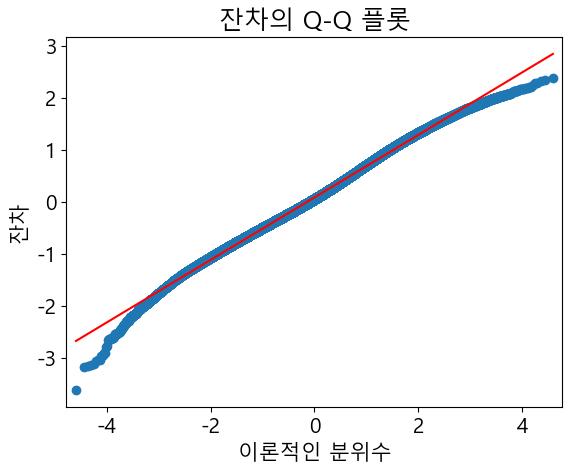

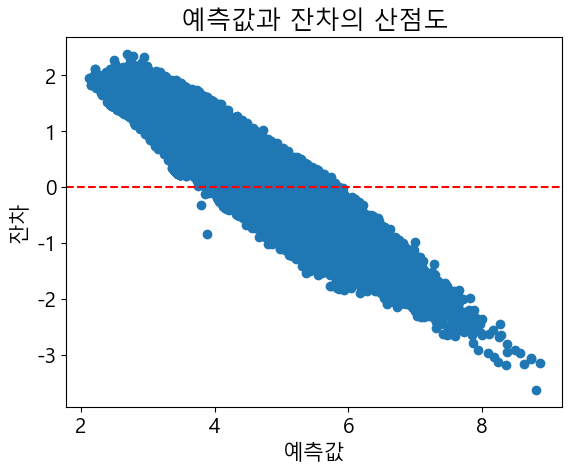

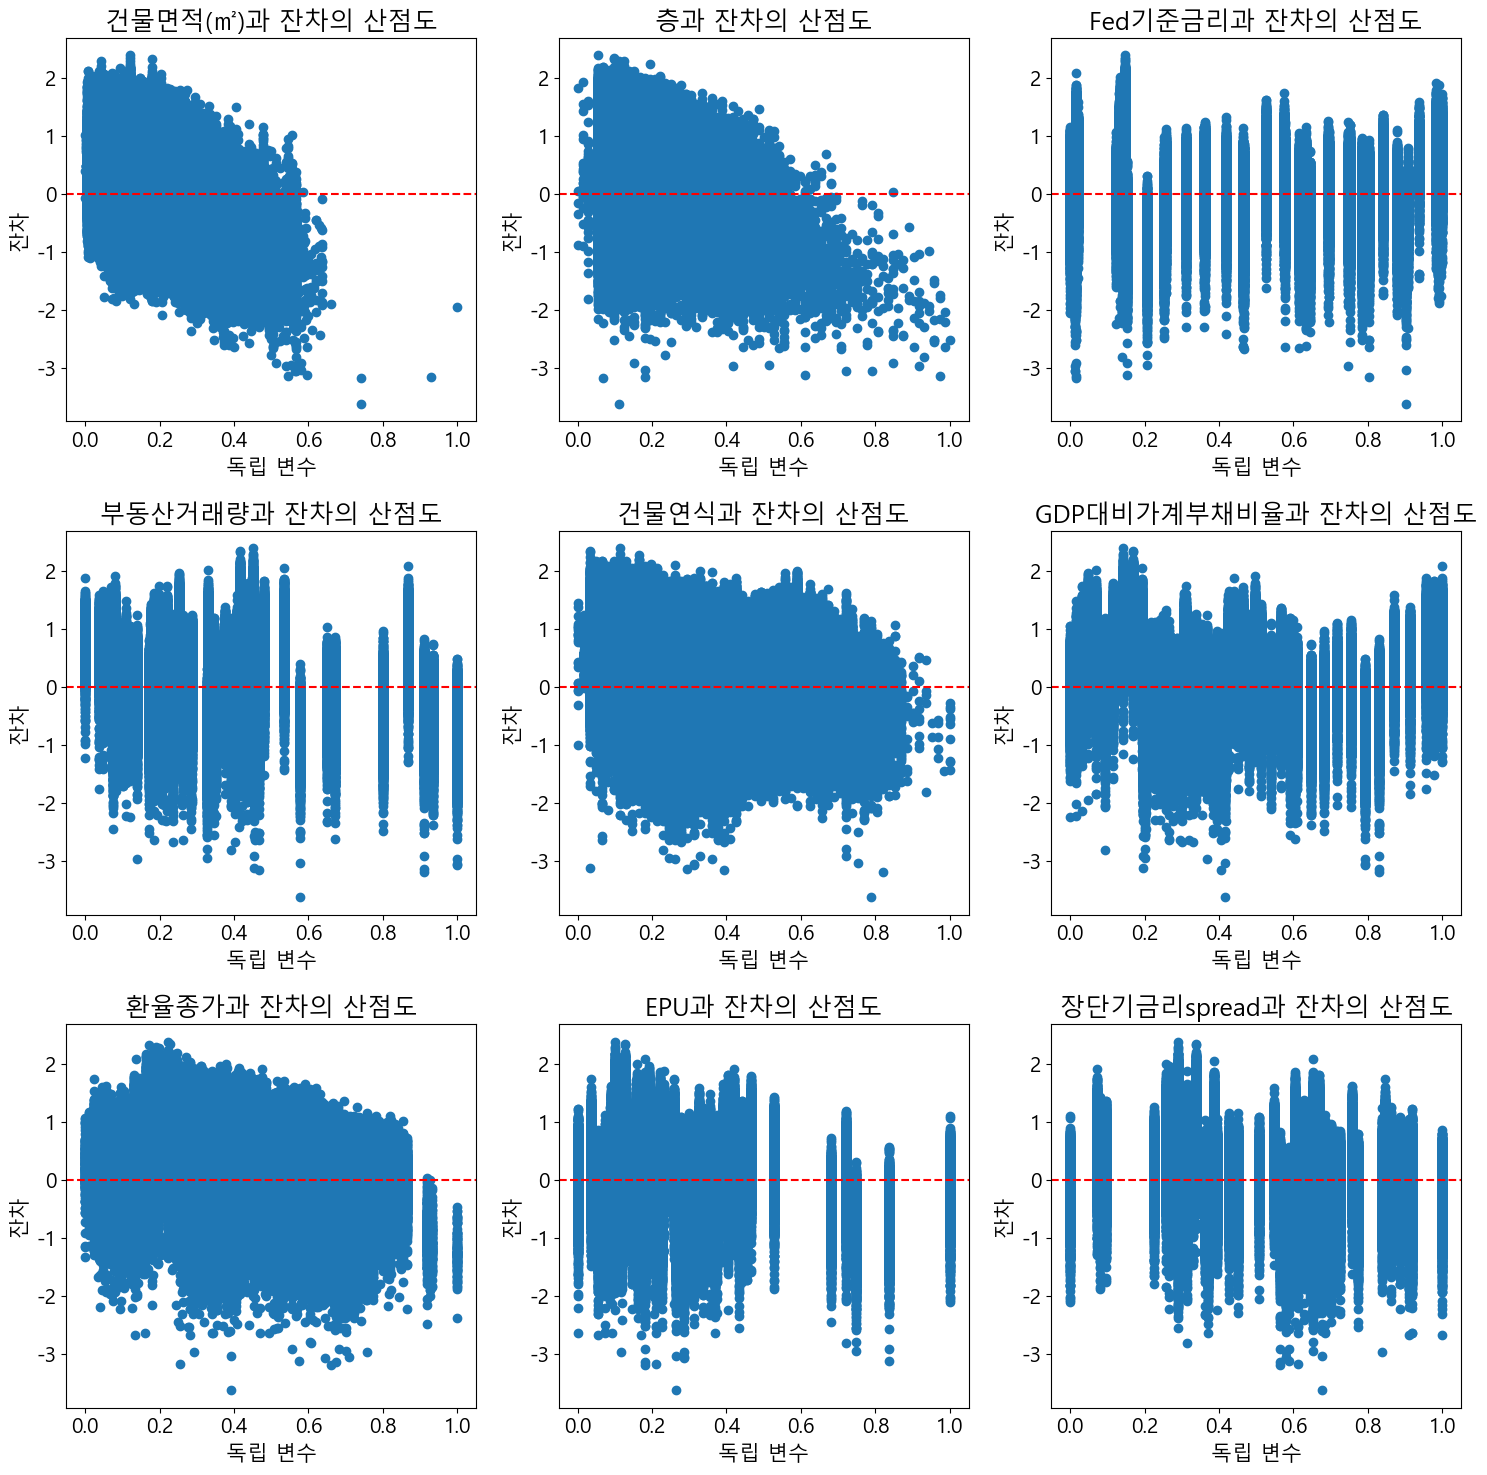

In [276]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

x = X_scaled_5
y = y_scaled

# 모델 적합
model = sm.OLS(y, x)  # 종속 변수 y와 독립 변수 X를 지정하여 모델 생성
result = model.fit()  # 모델 적합

# 잔차 추출
residuals = result.resid

# 잔차 분석
# 잔차의 정규성 확인: 잔차의 분포를 정규분포와 비교하여 정규성 검정을 수행합니다.
sm.qqplot(residuals, line='s')  # Q-Q plot을 그려서 정규성 확인
plt.xlabel('이론적인 분위수')
plt.ylabel('잔차')
plt.title('잔차의 Q-Q 플롯')
plt.show()

# 잔차의 등분산성 확인: 잔차와 예측값 사이의 관계를 살펴서 등분산성을 확인합니다.
plt.scatter(result.fittedvalues, residuals)
plt.xlabel('예측값')
plt.ylabel('잔차')
plt.title('예측값과 잔차의 산점도')
plt.axhline(y=0, color='red', linestyle='--')  # 잔차가 0인 기준선 추가
plt.show()

# 잔차의 독립성 확인: 잔차와 독립 변수 간의 관계를 살펴서 독립성을 확인합니다.
num_cols = len(x.columns)
num_rows = math.ceil(num_cols / 3)  # 3개의 열로 나누어 출력하고자 한다면
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))
for i in range(num_cols):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.scatter(x.iloc[:, i], residuals)
    ax.set_xlabel('독립 변수')
    ax.set_ylabel('잔차')
    ax.set_title(f'{x.columns[i]}과 잔차의 산점도')
    ax.axhline(y=0, color='red', linestyle='--')  # 잔차가 0인 기준선 추가

plt.tight_layout()  # 그래프 간격 조정
plt.show()